In [1]:
import ROOT
from ROOT import TMVA
import uproot
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('axes', **{'grid':False, 'titlesize':'large', 'labelsize':'large'})
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

import seaborn as sns

Welcome to JupyROOT 6.24/00


In [2]:
dirOutPath = '/data/Skim/'

listDir = os.listdir(dirOutPath)

In [48]:
SignalFlat = [0]*4
MCFlat = [0]*4

for i in range(1,5):
    SignalFlat[i-1] = uproot.open(dirOutPath + 'SignalFlat{}.root:Events'.format(i)).arrays(library='pd')
    MCFlat[i-1] = uproot.concatenate(dirOutPath + 'MC*{}.root:Events'.format(i), allow_missing=True, library='pd')
    
    SignalFlat[i-1]['label'] = 'signal'
    MCFlat[i-1]['label'] = 'bkg'
    
diLepton = pd.concat((SignalFlat[0], SignalFlat[1]))
triLepton = pd.concat((SignalFlat[2], SignalFlat[3]))

diLepton = pd.concat((diLepton, MCFlat[0], MCFlat[1]))
triLepton = pd.concat((triLepton, MCFlat[2], MCFlat[3]))

In [49]:
# drop weights
diLepton = diLepton.drop(columns=['eventWeightLumi', 'lep_mass0', 'lep_mass1'])
triLepton = triLepton.drop(columns=['eventWeightLumi', 'lep_mass0', 'lep_mass1', 'lep_mass2', 'lep_pt0'])

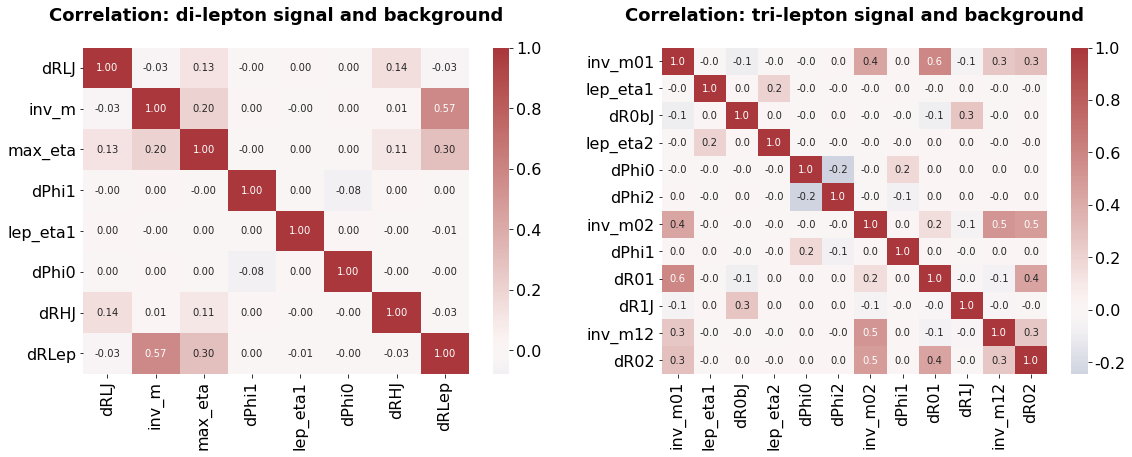

In [52]:
di_corr = diLepton.corr()
tri_corr = triLepton.corr()

f_corr, (ax_di_corr, ax_tri_corr) = plt.subplots(nrows=1, ncols=2, figsize=(19,6))
ax_di_corr.set_title('Correlation: di-lepton signal and background\n', fontweight="bold", size=18)
tabc_sgn = sns.heatmap(di_corr, center=0, cmap='vlag', annot=True, fmt='.2f', linewidths=0,
            xticklabels=di_corr.columns.values, yticklabels=di_corr.columns.values, ax=ax_di_corr)

ax_tri_corr.set_title('Correlation: tri-lepton signal and background\n', fontweight="bold", size=18)
tabc_corr = sns.heatmap(tri_corr, center=0, cmap='vlag', annot=True, fmt='.1f', linewidths=0,
            xticklabels=tri_corr.columns.values, yticklabels=tri_corr.columns.values, ax=ax_tri_corr)

## Load data

In [6]:
def loadData(chain, pathDirs, info=False):
    # Set up multi-threading capability of ROOT
    ROOT.ROOT.EnableImplicitMT()
    
    for file in pathDirs:
        if info: print('>>> Process directory ', Dir)
        tmp = ROOT.TFile.Open(dirOutPath + file)
        try:
            tmp.Get("Events").GetEntries()
            chain.Add(dirOutPath + file)
        except:
            continue
            
    return chain

def returnFiles(string, nSkim):
    return [filename for filename in listDir if (filename.startswith(string) and filename.endswith(str(nSkim)+'.root'))]

In [7]:
bkg_files2 = returnFiles('MC',1) + returnFiles('MC',2)
bkg_files3 = returnFiles('MC',3) + returnFiles('MC',4)
sig_files2 = returnFiles('Sig',1) + returnFiles('Sig',2)
sig_files3 = returnFiles('Sig',3) + returnFiles('Sig',4)
dat_files2 = returnFiles('Dat',1) + returnFiles('Dat',2)
dat_files3 = returnFiles('Dat',3) + returnFiles('Dat',4)

### BKG ###
chain_bkg2 = ROOT.TChain('Events')
chain_bkg2 = loadData(chain_bkg2, bkg_files2)

chain_bkg3 = ROOT.TChain('Events')
chain_bkg3 = loadData(chain_bkg3, bkg_files3)

### SIGNAL ###
chain_sig2 = ROOT.TChain('Events')
chain_sig2 = loadData(chain_sig2, sig_files2)

chain_sig3 = ROOT.TChain('Events')
chain_sig3 = loadData(chain_sig3, sig_files3)

### DATA ###
chain_dat2 = ROOT.TChain('Events')
chain_dat2 = loadData(chain_dat2, dat_files2)

chain_dat3 = ROOT.TChain('Events')
chain_dat3 = loadData(chain_dat3, dat_files3)

## Add variables

In [8]:
signalWeight     = 1.0
backgroundWeight = 1.0


### LOADER 2 ###
loader2 = ROOT.TMVA.DataLoader("dataset")

loader2.AddSignalTree(chain_sig2, signalWeight)
loader2.AddBackgroundTree(chain_bkg2, backgroundWeight)

var2 = ['max_eta','lep_eta1','inv_m','dRHJ','dRLJ','dPhi0','dPhi1']
for var in var2:
    loader2.AddVariable(var)


### LOADER 3 ###
loader3 = ROOT.TMVA.DataLoader("dataset")

loader3.AddSignalTree(chain_sig3, signalWeight)
loader3.AddBackgroundTree(chain_bkg3, backgroundWeight)

var3 = ['inv_m01','lep_eta1','lep_eta2','inv_m12','dR1J','dR0bJ','dR01','dPhi0','dPhi1','dPhi2']

for var in var3:
    loader3.AddVariable(var)


<HEADER> DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Events of type Signal with 8323 events
<HEADER> DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Events of type Background with 121758 events
<HEADER> DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Events of type Signal with 5107 events
<HEADER> DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Events of type Background with 161067 events


In [6]:
void_cut = ROOT.TCut('')

loader2.PrepareTrainingAndTestTree(void_cut, void_cut,
                                  "nTrain_Signal=6659:nTrain_Background=97407:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )
loader3.PrepareTrainingAndTestTree(void_cut, void_cut,
                                  "nTrain_Signal=4086:nTrain_Background=128854:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## Model selection

In [ ]:
%%capture

outputFileGrid = ROOT.TFile.Open("gridClassification.root", "RECREATE")

factoryGrid = ROOT.TMVA.Factory("TMVA_Classification", outputFileGrid,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

nTrees = [10, 20, 50, 100, 400, 800]
boost = ['AdaBoost', 'Bagging', 'Grad']

for tree in nTrees:
    for boo in boost:
        str2 = "BDT2_{}_{}".format(tree,boo)
        str3 = "BDT3_{}_{}".format(tree,boo)

        factoryGrid.BookMethod(loader2,ROOT.TMVA.Types.kBDT, str2,
               "!V:NTrees={}:MinNodeSize=2.5%:MaxDepth=3:BoostType={}:"
               "SeparationType=SDivSqrtSPlusB".format(tree,boo) )

        factoryGrid.BookMethod(loader3,ROOT.TMVA.Types.kBDT, str3,
               "!V:NTrees={}:MinNodeSize=2.5%:MaxDepth=3:BoostType={}:"
               "SeparationType=SDivSqrtSPlusB".format(tree,boo) )
            
factoryGrid.TrainAllMethods()
factoryGrid.TestAllMethods()
factoryGrid.EvaluateAllMethods()
outputFileGrid.Close()


## Train & test

In [8]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("Classification.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_Classification", outputFile,
                      "!V:ROC:Color:!DrawProgressBar:AnalysisType=Classification" )

In [9]:
factory.BookMethod(loader2,ROOT.TMVA.Types.kBDT, "BDT2",
                   "!V:NTrees=100:MinNodeSize=2.5%:MaxDepth=3:BoostType=Grad:"
                   "SeparationType=SDivSqrtSPlusB" )

factory.BookMethod(loader3,ROOT.TMVA.Types.kBDT, "BDT3",
                   "!V:NTrees=20:MinNodeSize=2.5%:MaxDepth=3:BoostType=Grad:"
                   "SeparationType=SDivSqrtSPlusB" )

Factory                  : Booking method: BDT2
                         : 
                         : the option NegWeightTreatment=InverseBoostNegWeights does not exist for BoostType=Grad
                         : --> change to new default NegWeightTreatment=Pray
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Event

In [10]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'max_eta' <---> Output : variable 'max_eta'
                         : Input : variable 'lep_eta1' <---> Output : variable 'lep_eta1'
                         : Input : variable 'inv_m' <---> Output : variable 'inv_m'
                         : Input : variable 'dRHJ' <---> Output : variable 'dRHJ'
                         : Input : variable 'dRLJ' <---> Output : variable 'dRLJ'
                         : Input : variable 'dPhi0' <---> Output : variable 'dPhi0'
                         : Input : variable 'dPhi1' <---> Output : variable 'dPhi1'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------

In [11]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: BDT2 for Classification performance
                         : 
BDT2                     : [dataset] : Evaluation of BDT2 on testing sample (26015 events)
                         : Elapsed time for evaluation of 26015 events: 0.0957 sec       
Factory                  : Test method: BDT3 for Classification performance
                         : 
BDT3                     : [dataset] : Evaluation of BDT3 on testing sample (33234 events)
                         : Elapsed time for evaluation of 33234 events: 0.0266 sec       


In [12]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT2
                         : 
BDT2                     : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT2           : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :  max_eta:     1.3509    0.58068   [   0.011782     2.4556 ]
                         : lep_eta1: -0.0078649     1.2106   [    -2.4556     2.4521 ]
                         :    inv_m:     146.44     114.62   [     15.019     1820.2 ]
                         :     dRHJ:     1.2150    0.53934   [    0.40024     4.0780 ]
                         :     dRLJ:     1.1642    0.50397   [    0.40057     3.6893 ]
                         :    dPhi0: -0.0030660     1.7183   [    -3.1412     3.1413 ]
                         :    dPhi1:  

In [13]:
outputFile.Close()

AUC diLepton 0.6650219876256863
AUC triLepton 0.7927925448972688


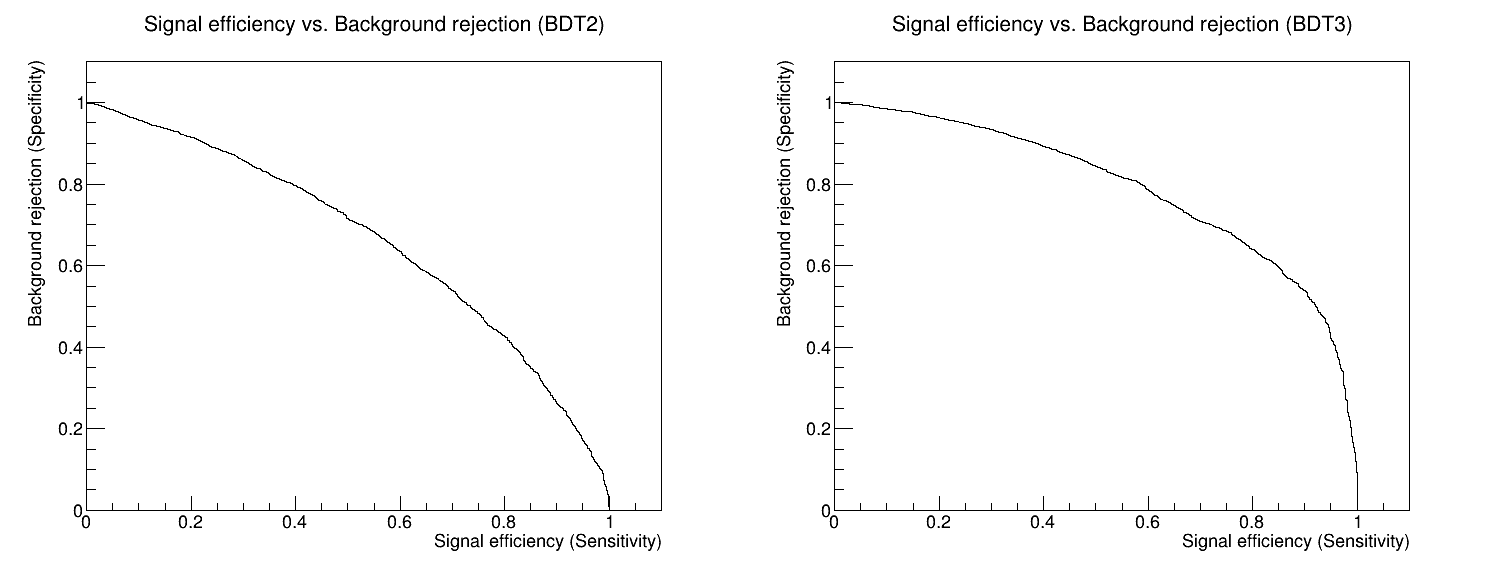

In [14]:
c = ROOT.TCanvas('','',1500,600)
c.Divide(2,1)
c.cd(1)
roc = factory.GetROCCurve(loader2, 'BDT2')
roc.Draw()
print('AUC diLepton', factory.GetROCIntegral(loader2, 'BDT2'))
c.cd(2)
roc = factory.GetROCCurve(loader3, 'BDT3')
roc.Draw()
print('AUC triLepton', factory.GetROCIntegral(loader3, 'BDT3'))
c.Draw()

## Evaluation

In [9]:
read = ROOT.TFile.Open('Classification.root')

In [10]:
from array import array
max_eta = array('f',[0])
lep_eta1 = array('f',[0])
inv_m = array('f',[0])
dRHJ = array('f',[0])
dRLJ = array('f',[0])
dPhi0 = array('f',[0])
dPhi1 = array('f',[0])

sig_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_S')
bkg_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_B')

nbins = sig_hist.GetXaxis().GetNbins()
xmin = sig_hist.GetXaxis().GetXmin()
xmax = sig_hist.GetXaxis().GetXmax()

reader = TMVA.Reader("evaluation")

reader.AddVariable("max_eta", max_eta)
reader.AddVariable("lep_eta1", lep_eta1)
reader.AddVariable("inv_m", inv_m)
reader.AddVariable("dRHJ", dRHJ)
reader.AddVariable("dRLJ", dRLJ)
reader.AddVariable("dPhi0", dPhi0)
reader.AddVariable("dPhi1", dPhi1)

weightfile = "dataset/weights/TMVA_Classification_BDT2.weights.xml"

reader.BookMVA('BDT2', weightfile)

d2 = ROOT.TH1D("d2","Classifier Output on Data Events",30,-1,1)
s2 = ROOT.TH1D("s2","Classifier Output on Signal Events",30,-1,1)
b2 = ROOT.TH1D('b2',"Classifier Output on Background Events",30,-1,1)

for entry in chain_dat2:
    
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    d2.Fill(output)
    
for entry in chain_sig2:
    
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    s2.Fill(output)
    
for entry in chain_bkg2:
    
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    b2.Fill(output, entry.eventWeightLumi)

                         : Booking "BDT2" of type "BDT" from dataset/weights/TMVA_Classification_BDT2.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Classification_BDT2.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT2" of type: "BDT"


In [11]:
from array import array
inv_m01 = array('f',[0])
lep_eta1 = array('f',[0])
lep_eta2 = array('f',[0])
inv_m12 = array('f',[0])
dR1J = array('f',[0])
dR0bJ = array('f',[0])
dR01 = array('f',[0])
dPhi0 = array('f',[0])
dPhi1 = array('f',[0])
dPhi2 = array('f',[0])

sig_hist = read.Get('dataset/Method_BDT/BDT3/MVA_BDT3_S')
bkg_hist = read.Get('dataset/Method_BDT/BDT3/MVA_BDT3_B')

nbins = sig_hist.GetXaxis().GetNbins()
xmin = sig_hist.GetXaxis().GetXmin()
xmax = sig_hist.GetXaxis().GetXmax()

reader = TMVA.Reader("evaluation")

reader.AddVariable("inv_m01", inv_m01)
reader.AddVariable("lep_eta1", lep_eta1)
reader.AddVariable("lep_eta2", lep_eta2)
reader.AddVariable("inv_m12", inv_m12)
reader.AddVariable("dR1J", dR1J)
reader.AddVariable("dR0bJ", dR0bJ)
reader.AddVariable("dR01", dR01)
reader.AddVariable("dPhi0", dPhi0)
reader.AddVariable("dPhi1", dPhi1)
reader.AddVariable("dPhi2", dPhi2)

weightfile = "dataset/weights/TMVA_Classification_BDT3.weights.xml"

reader.BookMVA('BDT3', weightfile)

d3 = ROOT.TH1D("d3","Classifier Output on Data Events",30,-1,1)
s3 = ROOT.TH1D("s3","Classifier Output on Signal Events",30,-1,1)
b3 = ROOT.TH1D("b3","Classifier Output on Background Events",30,-1,1)

for entry in chain_dat3:
    
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    d3.Fill(output)
    
for entry in chain_sig3:
    
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    s3.Fill(output)
    
for entry in chain_bkg3:
    
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    b3.Fill(output, entry.eventWeightLumi)

                         : Booking "BDT3" of type "BDT" from dataset/weights/TMVA_Classification_BDT3.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Classification_BDT3.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT3" of type: "BDT"


In [64]:
def plot_bdt(data, sig, bkg):    
    # Styles
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)
    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)
    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)
    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)
    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)
    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')
    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)
    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)
    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    
    c = ROOT.TCanvas('', '', 600, 600)
    c.cd()
    
    sig.SetLineColor(ROOT.TColor.GetColor('#00A88F'))
    sig.SetLineWidth(3)
    sig.Draw('HIST')
    
    bkg.SetLineColor(2)
    bkg.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
    bkg.SetLineWidth(3)
    bkg.Draw('E2 hist same')
    
    
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
    data.Draw('E1P SAME')
    
    sig.GetXaxis().SetTitle("BDT discriminant")
    sig.GetYaxis().SetTitle('N_{Events}')
    
     # Add legend
    legend = ROOT.TLegend(0.2, 0.7, 0.5, 0.9)
    legend.SetNColumns(2)
    legend.AddEntry(sig, 'Signal', 'f')
    legend.AddEntry(bkg, 'Background', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    
    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{Boosted Decison Tree}')
    
    c.Draw()
    
    return legend

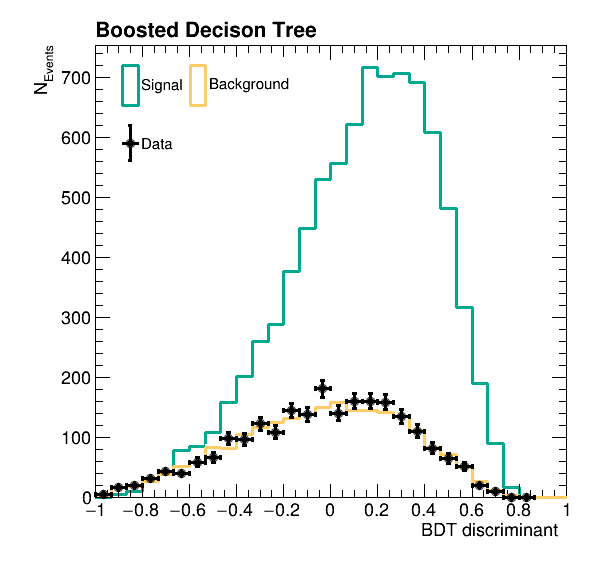

In [65]:
l = plot_bdt(d2, s2, b2)
l.Draw()

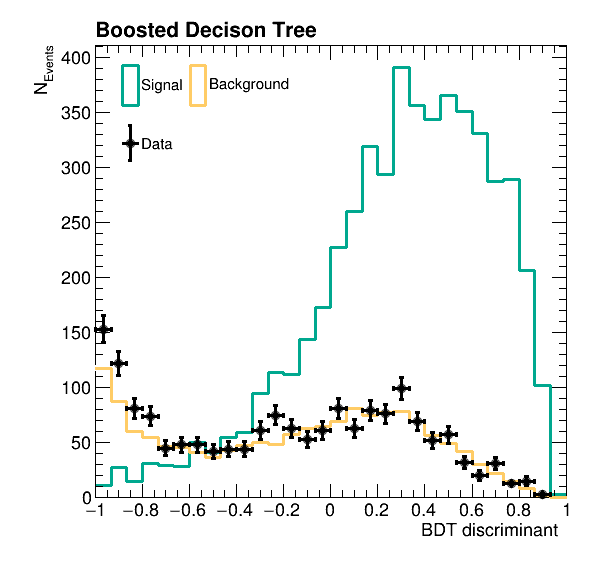

In [66]:
l = plot_bdt(d3, s3, b3)
l.Draw()

## Statistics

In [36]:
import scipy as sp
from scipy.stats import poisson as ps

def stat(data_hist, sig_hist, bkg_hist):
    
    np.random.seed(12345)
    
    nbins, data, sig, bkg = 0, [], [], []
    
    for d,s,b in zip(data_hist,sig_hist,bkg_hist):

        tmp_bins = d.GetXaxis().GetNbins()
        data += [d.GetBinContent(i) for i in range(1, tmp_bins+1)]
        sig += [s.GetBinContent(i) for i in range(1, tmp_bins+1)]
        bkg += [b.GetBinContent(i) for i in range(1, tmp_bins+1)]
        nbins += tmp_bins
            
    data = np.array(data)
    sig = np.array(sig)
    bkg = np.array(bkg)
    data[data<0] = 0
    sig[sig<0] = 0
    bkg[bkg<0] = 0
        
    mu_grid = np.arange(0, 0.1, 1e-6)
    
    b_plus_sig = np.outer(sig, mu_grid) + np.tile(bkg,(len(mu_grid),1)).T
    
    like_grid = np.prod(ps.pmf(np.tile(data,(len(mu_grid),1)).T, b_plus_sig), axis=0)
    mu_best = mu_grid[np.argmax(like_grid)]
    b_plus_sig_best = bkg + sig*mu_best
      
    ntoys = int(5e5)
    bin_toys = 1000
    
    mu_min = 0.012
    mu_max = 0.015

    for i in range(10):
        mu = (mu_min+mu_max)/2
        #mu = 0.012
        
        b_plus_sig_mu = bkg + sig*mu
        toys = ps.rvs(np.tile(b_plus_sig_mu,(ntoys,1)).T, size=(nbins,ntoys))
        
        like_num0 = np.prod(ps.pmf(toys, np.tile(bkg,(ntoys,1)).T), axis=0)
        like_num1 = np.prod(ps.pmf(toys, np.tile(b_plus_sig_mu,(ntoys,1)).T), axis=0)
        like_den = np.prod(ps.pmf(toys, np.tile(b_plus_sig_best,(ntoys,1)).T), axis=0)
    
        q_mu0 = -2 * np.log(like_num0/like_den)
        q_mu1 = -2 * np.log(like_num1/like_den)
        
        like_num_obs = np.prod(ps.pmf(data, b_plus_sig_mu))
        like_den_obs = np.prod(ps.pmf(data, b_plus_sig_best))
        q_mu_obs = -2 * np.log(like_num_obs/like_den_obs)
        
        ### H0 ###
        values_0, bins_0, _ = plt.hist(q_mu0, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_0 > q_mu_obs)
        p_b = sum(np.diff(bins_0[mask])*values_0[mask[:-1]])
        
        ### H1 ###
        values_1, bins_1, _ = plt.hist(q_mu1, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_1 > q_mu_obs)
        p_mu = sum(np.diff(bins_1[mask])*values_1[mask[:-1]])
        
        if p_b == 0:
            mu_max = mu
            continue
        
        #CL.append(p_mu/p_b)
        #significance.append(-sp.stats.norm.ppf(p_b))
        
        CL = p_mu/p_b
        
        if CL < 0.05: mu_max = mu
        else: mu_min = mu   
    significance = abs(sp.stats.norm.ppf(p_b))
    
    plt.figure(figsize=(8, 5))
    plt.hist(q_mu0, bins=bin_toys, alpha=0.5, color='red', density=True, label='$H_0$')
    plt.hist(q_mu1, bins=bin_toys, alpha=0.5, color='blue', density=True, label='$H_1$')
    plt.ylim((0,0.15))
    plt.axvline(q_mu_obs, color='#00A88F', label='$q^{obs}(\mu)$')
    plt.xlabel(r'$q(\mu)$')
    plt.legend(frameon=False, prop={'size': 18})
    plt.show()
        
    return mu_best, mu, CL, significance    

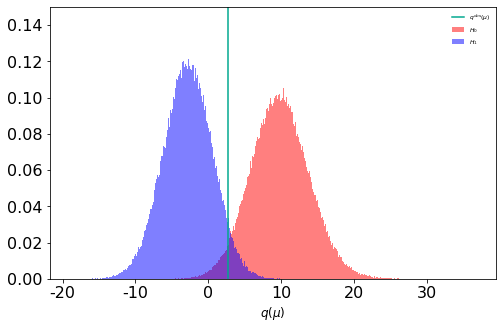

In [37]:
plt.rc('axes', unicode_minus=False)
mu_hat, upper_lim, CL, sig = stat((d2,d3), (s2,s3), (b2,b3))

In [44]:
print('value of \u03BC maximizing the likelihood:\t',mu_hat)
print('value of the inferred upper limit of \u03BC:\t',upper_lim)
print('CL:\t\t\t\t\t',CL)
print('significance:\t\t\t\t',sig)

value of μ maximizing the likelihood:	 0.006599
value of the inferred upper limit of μ:	 0.012776367187500002
CL:					 0.04939792972325905
significance:				 1.8206242105791797


## Varie ed eventuali

In [ ]:
read = ROOT.TFile('diLeptonClassification.root')
sig_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_effS')
bkg_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_effB')

bins = sig_hist.GetXaxis().GetNbins()
sig = np.array([sig_hist.GetBinContent(i) for i in range(1, bins+1)])
bkg = np.array([bkg_hist.GetBinContent(i) for i in range(1, bins+1)])

x = np.linspace(-0.5,0.4,bins)
signif = sig/np.sqrt(bkg)
n = len(signif)
rms = np.sqrt(1/n * sum(signif))

plt.figure(figsize=(8, 5))
plt.plot(x, signif, color='k')
plt.fill_between(x, signif - rms, signif + rms, alpha=0.2, color = 'fuchsia', label='$\mathrm{RMS}$')
plt.axvline(x[signif.argmax()], color='#00A88F', label='max')
plt.xlabel(r'$q(\mu)$')
plt.ylabel(r'$S_{eff}/\sqrt{B_{eff}}$')
plt.legend(frameon=False)
plt.show()

In [ ]:
sig_hist.GetTitle()

In [ ]:
c1 = ROOT.TCanvas()
c1.cd()
err.Draw('hist')
c1.Draw()

In [ ]:
hist.GetXaxis().GetXmin()

In [ ]:
read.ls()

In [ ]:
read = ROOT.TFile('Classification.root')
sig_hist = read.Get('dataset/Method_BDT/BDT3/MVA_BDT3_trainingEffBvsS')

In [ ]:
c = ROOT.TCanvas()
c.cd()
sig_hist.Draw()
c.Draw()

In [ ]:
read = uproot.open('Classification.root')

In [ ]:
read.classnames()